# Prepare data for training neural networks

In [1]:
import os

In [2]:
ll

total 372440
-rw-r--r--@    1 cham  staff  111699409 May  8 17:34 catalog.csv
-rw-r--r--     1 cham  staff     149760 May  8 17:43 catalog.fits
-rw-r--r--     1 cham  staff   20280485 May  8 23:37 data.bz2
-rw-r--r--@    1 cham  staff   57587575 May  8 17:32 fits-217172630.tar.gz
-rw-r--r--     1 cham  staff      79138 May  8 23:37 neural_network.ipynb
-rw-r--r--     1 cham  staff     135871 May  8 23:37 preparation.ipynb
drwx------@ 1002 cham  staff      32064 May  8 17:36 spec/


In [3]:
import numpy as np
from astropy.table import Table

In [4]:
t = Table.read("catalog.fits", format="fits")
t

combined_obsid,combined_obsdate,combined_lmjd,combined_mjd,combined_planid,combined_spid,combined_fiberid,combined_class,combined_subclass,combined_z,combined_ra,combined_dec,combined_logg,combined_rv,combined_teff,combined_feh
int64,bytes10,int64,int64,bytes20,int64,int64,bytes4,bytes10,float64,float64,float64,float64,float64,float64,float64
104132,2011-10-24,55859,55858,F5902,4,132,STAR,G0,0.0001120108,331.84967,-0.11543,4.156,33.58,5851.11,-0.35
106102,2011-10-24,55859,55858,F5902,6,102,STAR,K0,3.10215e-05,334.32611,-0.46919,3.695,9.3,5062.59,0.134
106160,2011-10-24,55859,55858,F5902,6,160,STAR,K3,8.12562e-05,334.26706,-0.15868,2.268,24.36,4295.81,-0.368
201195,2011-10-24,55859,55858,F5907,1,195,STAR,A2,-2.42501e-05,45.6028883,-2.8128045,4.094,-7.27,9852.01,-0.257
203205,2011-10-24,55859,55858,F5907,3,205,STAR,F0,-0.0003755598,44.02034,-0.08118,4.271,-112.59,6639.15,-0.862
204075,2011-10-24,55859,55858,F5907,4,75,STAR,A2,-0.00027461,45.1899651,-0.4169173,--,--,--,--
209118,2011-10-24,55859,55858,F5907,9,118,STAR,F0,-1.52105e-05,45.3565549,0.3453113,4.105,-4.56,6832.99,0.013
210231,2011-10-24,55859,55858,F5907,10,231,STAR,F9,0.0002571779,43.46004,-0.86671,4.188,77.1,5579.44,-0.082
212016,2011-10-24,55859,55858,F5907,12,16,STAR,A7,5.651e-05,46.389458,0.820169,--,--,--,--


In [5]:
from laspec.mrs import MrsSpec
from tqdm import trange

# read spectra
wave_grid = np.arange(4000, 5500, dtype=float)

filelist = []
flux = []
flux_err = []

for irow in trange(len(t)):
    this_lmjd = t[irow]["combined_lmjd"]
    this_planid = t[irow]["combined_planid"]
    this_spid = t[irow]["combined_spid"]
    this_fiberid = t[irow]["combined_fiberid"]
    this_rv = t[irow]["combined_rv"]
    if t["combined_feh"].mask[irow]:
        continue
    
    filename = f"spec/spec-{this_lmjd}-{this_planid}_sp{this_spid:02d}-{this_fiberid:03d}.fits.gz"
    # assert file exists
    assert os.path.exists(filename)
    filelist.append(filename)
    
    # read spectra
    spec = MrsSpec.from_lrs(filename)
    this_flux, this_flux_err = spec.interp_then_norm(new_wave=wave_grid, rv=this_rv)
    
    flux.append(this_flux)
    flux_err.append(this_flux_err)

flux = np.array(flux)
flux_err = np.array(flux_err)
labels = np.array(t["combined_teff", "combined_logg", "combined_feh", ][~t["combined_feh"].mask].to_pandas())

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.86it/s]


Text(0, 0.5, 'Normalized flux')

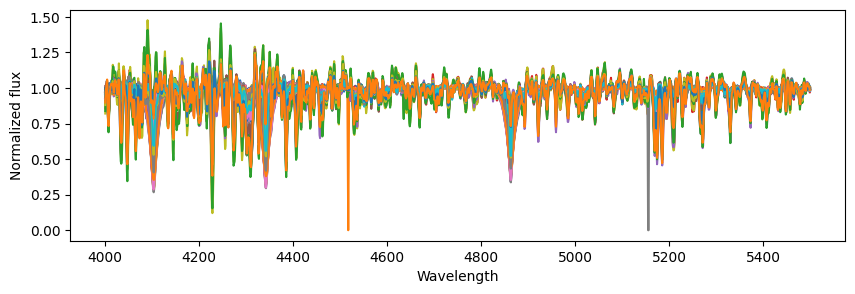

In [6]:
# plot spectra
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 3))
plt.plot(wave_grid, flux[::10].T)
plt.xlabel("Wavelength")
plt.ylabel("Normalized flux")

In [7]:
flux.shape, flux_err.shape, labels.shape

((913, 1500), (913, 1500), (913, 3))

In [8]:
import joblib
joblib.dump((flux, flux_err, labels), "data.bz2")

['data.bz2']